In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys
print("Python executable:", sys.executable)

Python executable: C:\Users\krant\AppData\Local\Programs\Python\Python311\python.exe


In [3]:
import os
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [4]:
import os
os.environ['SPARK_LOCAL_HOSTNAME'] = 'localhost'

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("PySpark_Jupyter_Test") \
    .master("local[*]") \
    .getOrCreate()

print("✅ Spark version:", spark.version)

✅ Spark version: 4.0.1


In [5]:
import os
import sys
from pyspark.sql import SparkSession

# Set environment variables
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Create Spark session with explicit configuration
spark = SparkSession.builder \
    .appName("PythonVersionFix") \
    .config("spark.pyspark.python", sys.executable) \
    .config("spark.pyspark.driver.python", sys.executable) \
    .getOrCreate()

# Test the setup
print("Spark session created successfully!")
print(f"Python version: {sys.version}")

# Your Spark code here
# df = spark.read.csv("your_file.csv")
# ...

#spark.stop()

Spark session created successfully!
Python version: 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]


In [6]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("BWSSB_Water_Consumption_Analysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

# Set log level to WARN to reduce verbose output
spark.sparkContext.setLogLevel("WARN")

print("Spark session initialized successfully!")

Spark session initialized successfully!


In [7]:
# Define the schema for the dataset
schema = StructType([
    StructField("Ward_number", IntegerType(), True),
    StructField("Ward_Name", StringType(), True),
    StructField("Number_of_Connections", IntegerType(), True),
    StructField("Consumption_in_ML", DoubleType(), True),
    StructField("avg_household_size", IntegerType(), True),
    StructField("income_level", StringType(), True),
    StructField("water_efficiency", DoubleType(), True)
])

# Load the CSV data
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "false") \
    .schema(schema) \
    .csv("BWSSB_Water_Consumption_August_2025_Extended_Filled.csv")

# Show basic information about the dataset
print("Dataset Schema:")
df.printSchema()

print(f"Total number of records: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Dataset Schema:
root
 |-- Ward_number: integer (nullable = true)
 |-- Ward_Name: string (nullable = true)
 |-- Number_of_Connections: integer (nullable = true)
 |-- Consumption_in_ML: double (nullable = true)
 |-- avg_household_size: integer (nullable = true)
 |-- income_level: string (nullable = true)
 |-- water_efficiency: double (nullable = true)

Total number of records: 5000
Number of columns: 7


In [8]:
# Check for null values in each column
print("Null values in each column:")
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

# Check for duplicate rows
duplicate_count = df.count() - df.distinct().count()
print(f"Number of duplicate rows: {duplicate_count}")

# Basic statistics for numerical columns
print("Basic Statistics for Numerical Columns:")
df.describe("Number_of_Connections", "Consumption_in_ML", "avg_household_size", "water_efficiency").show()

# Check unique values in categorical columns
print("Unique income levels:")
df.select("income_level").distinct().show()

Null values in each column:
+-----------+---------+---------------------+-----------------+------------------+------------+----------------+
|Ward_number|Ward_Name|Number_of_Connections|Consumption_in_ML|avg_household_size|income_level|water_efficiency|
+-----------+---------+---------------------+-----------------+------------------+------------+----------------+
|          0|        0|                    0|                0|                 0|           0|               0|
+-----------+---------+---------------------+-----------------+------------------+------------+----------------+

Number of duplicate rows: 0
Basic Statistics for Numerical Columns:
+-------+---------------------+------------------+------------------+-------------------+
|summary|Number_of_Connections| Consumption_in_ML|avg_household_size|   water_efficiency|
+-------+---------------------+------------------+------------------+-------------------+
|  count|                 5000|              5000|              5000

In [9]:
# Handle any null values (if any exist)
df_clean = df.fillna({
    'Number_of_Connections': 0,
    'Consumption_in_ML': 0.0,
    'avg_household_size': 0,
    'water_efficiency': 0.0
})

# Create new features
df_enhanced = df_clean.withColumn(
    "consumption_per_connection", 
    when(col("Number_of_Connections") > 0, 
         col("Consumption_in_ML") / col("Number_of_Connections"))
    .otherwise(0)
).withColumn(
    "consumption_per_capita",
    when(col("Number_of_Connections") > 0, 
         col("Consumption_in_ML") / (col("Number_of_Connections") * col("avg_household_size")))
    .otherwise(0)
).withColumn(
    "ward_type",
    when(col("Ward_Name").like("Synthetic%"), "Synthetic")
    .otherwise("Real")
)

print("Enhanced Dataset with new features:")
df_enhanced.show(10)

Enhanced Dataset with new features:
+-----------+--------------------+---------------------+-----------------+------------------+------------+----------------+--------------------------+----------------------+---------+
|Ward_number|           Ward_Name|Number_of_Connections|Consumption_in_ML|avg_household_size|income_level|water_efficiency|consumption_per_connection|consumption_per_capita|ward_type|
+-----------+--------------------+---------------------+-----------------+------------------+------------+----------------+--------------------------+----------------------+---------+
|          1|     Kempegowda Ward|                 4247|           114.25|                 5|      Middle|            0.78|       0.02690134212385213|  0.005380268424770426|     Real|
|          2|   Chowdeshwari Ward|                  463|            23.62|                 6|        High|            0.67|       0.05101511879049676|  0.008502519798416127|     Real|
|          3|               Attur|          

In [10]:
# Summary statistics by income level
print("Summary by Income Level:")
income_summary = df_enhanced.groupBy("income_level").agg(
    avg("Consumption_in_ML").alias("avg_consumption"),
    avg("Number_of_Connections").alias("avg_connections"),
    avg("water_efficiency").alias("avg_efficiency"),
    count("*").alias("ward_count")
).orderBy("income_level")
income_summary.show()

# Consumption statistics by ward type
print("Statistics by Ward Type:")
ward_type_stats = df_enhanced.groupBy("ward_type").agg(
    count("*").alias("total_wards"),
    avg("Consumption_in_ML").alias("avg_consumption"),
    sum("Consumption_in_ML").alias("total_consumption"),
    avg("water_efficiency").alias("avg_efficiency")
)
ward_type_stats.show()

Summary by Income Level:
+------------+------------------+-----------------+------------------+----------+
|income_level|   avg_consumption|  avg_connections|    avg_efficiency|ward_count|
+------------+------------------+-----------------+------------------+----------+
|        High| 248.8582568807336|5030.491743119266|0.7506116207951079|      1635|
|         Low|251.58743013365745|5313.993317132442|0.7467679222357226|      1646|
|      Middle|248.09770796974993|5162.606748109366|0.7554741128563112|      1719|
+------------+------------------+-----------------+------------------+----------+

Statistics by Ward Type:
+---------+-----------+------------------+------------------+------------------+
|ward_type|total_wards|   avg_consumption| total_consumption|    avg_efficiency|
+---------+-----------+------------------+------------------+------------------+
|     Real|        202|151.38638613861383|30580.049999999992|0.7488613861386145|
|Synthetic|       4798|253.62569195498165| 1216896.

In [11]:
# Top 10 wards with highest consumption
print("Top 10 Wards by Water Consumption:")
top_consumption = df_enhanced.orderBy(col("Consumption_in_ML").desc()).limit(10)
top_consumption.select("Ward_number", "Ward_Name", "Consumption_in_ML", "income_level", "water_efficiency").show()

# Top 10 wards with highest efficiency
print("Top 10 Wards by Water Efficiency:")
top_efficiency = df_enhanced.orderBy(col("water_efficiency").desc()).limit(10)
top_efficiency.select("Ward_number", "Ward_Name", "water_efficiency", "Consumption_in_ML", "income_level").show()

# Bottom 10 wards with lowest efficiency
print("Bottom 10 Wards by Water Efficiency:")
bottom_efficiency = df_enhanced.orderBy(col("water_efficiency").asc()).limit(10)
bottom_efficiency.select("Ward_number", "Ward_Name", "water_efficiency", "Consumption_in_ML", "income_level").show()

Top 10 Wards by Water Consumption:
+-----------+-------------------+-----------------+------------+----------------+
|Ward_number|          Ward_Name|Consumption_in_ML|income_level|water_efficiency|
+-----------+-------------------+-----------------+------------+----------------+
|        174|         HSR Layout|           605.66|      Middle|            0.78|
|       4951|Synthetic Ward 4753|           499.98|        High|            0.84|
|       2603|Synthetic Ward 2405|           499.88|        High|             0.9|
|       2459|Synthetic Ward 2261|           499.75|         Low|            0.82|
|        820| Synthetic Ward 622|           499.66|         Low|            0.89|
|       2688|Synthetic Ward 2490|           499.28|         Low|            0.56|
|       3584|Synthetic Ward 3386|            499.2|        High|            0.62|
|       1020| Synthetic Ward 822|           499.18|        High|            0.82|
|       4146|Synthetic Ward 3948|           499.15|      Middle

In [12]:
# Using window functions for ranking
from pyspark.sql.window import Window

window_spec = Window.orderBy(col("Consumption_in_ML").desc())

df_ranked = df_enhanced.withColumn("consumption_rank", rank().over(window_spec)) \
    .withColumn("total_consumption", sum("Consumption_in_ML").over(Window.partitionBy().rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing))) \
    .withColumn("consumption_percentage", (col("Consumption_in_ML") / col("total_consumption")) * 100)

print("Top 20 Wards with Consumption Ranking:")
df_ranked.select("Ward_number", "Ward_Name", "Consumption_in_ML", "consumption_rank", "consumption_percentage") \
    .filter(col("consumption_rank") <= 20) \
    .show()

Top 20 Wards with Consumption Ranking:
+-----------+-------------------+-----------------+----------------+----------------------+
|Ward_number|          Ward_Name|Consumption_in_ML|consumption_rank|consumption_percentage|
+-----------+-------------------+-----------------+----------------+----------------------+
|        174|         HSR Layout|           605.66|               1|   0.04855082917338731|
|       4951|Synthetic Ward 4753|           499.98|               2|  0.040079324324060014|
|       2603|Synthetic Ward 2405|           499.88|               3|  0.040071308138547784|
|       2459|Synthetic Ward 2261|           499.75|               4|  0.040060887097381884|
|        820| Synthetic Ward 622|           499.66|               5|   0.04005367253042088|
|       2688|Synthetic Ward 2490|           499.28|               6|   0.04002321102547439|
|       3584|Synthetic Ward 3386|            499.2|               7|  0.040016798077064604|
|       1020| Synthetic Ward 822|        

In [13]:
# Calculate correlations between numerical variables
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Prepare numerical columns for correlation
numerical_cols = ["Number_of_Connections", "Consumption_in_ML", "avg_household_size", "water_efficiency"]
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
df_vector = assembler.transform(df_enhanced).select("features")

# Calculate correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()
correlation_array = correlation_matrix[0].toArray()

# Create correlation DataFrame for better visualization
corr_df = pd.DataFrame(correlation_array, columns=numerical_cols, index=numerical_cols)
print("Correlation Matrix:")
print(corr_df)

Correlation Matrix:
                       Number_of_Connections  Consumption_in_ML  \
Number_of_Connections               1.000000           0.034429   
Consumption_in_ML                   0.034429           1.000000   
avg_household_size                  0.010409          -0.033701   
water_efficiency                   -0.016029          -0.002671   

                       avg_household_size  water_efficiency  
Number_of_Connections            0.010409         -0.016029  
Consumption_in_ML               -0.033701         -0.002671  
avg_household_size               1.000000         -0.024418  
water_efficiency                -0.024418          1.000000  


In [14]:
# Detailed analysis by income level
income_detailed = df_enhanced.groupBy("income_level").agg(
    count("*").alias("ward_count"),
    avg("Consumption_in_ML").alias("avg_consumption"),
    stddev("Consumption_in_ML").alias("std_consumption"),
    avg("Number_of_Connections").alias("avg_connections"),
    avg("water_efficiency").alias("avg_efficiency"),
    sum("Consumption_in_ML").alias("total_consumption")
).orderBy("total_consumption", ascending=False)

print("Detailed Analysis by Income Level:")
income_detailed.show()

# Percentage distribution by income level
total_wards = df_enhanced.count()
income_distribution = df_enhanced.groupBy("income_level").agg(
    count("*").alias("count"),
    (count("*") / total_wards * 100).alias("percentage")
).orderBy("count", ascending=False)

print("Income Level Distribution:")
income_distribution.show()

Detailed Analysis by Income Level:
+------------+----------+------------------+------------------+-----------------+------------------+------------------+
|income_level|ward_count|   avg_consumption|   std_consumption|  avg_connections|    avg_efficiency| total_consumption|
+------------+----------+------------------+------------------+-----------------+------------------+------------------+
|      Middle|      1719|248.09770796974993|143.30325436305205|5162.606748109366|0.7554741128563112|426479.96000000014|
|         Low|      1646|251.58743013365745| 140.8464111898615|5313.993317132442|0.7467679222357226|414112.91000000015|
|        High|      1635| 248.8582568807336| 141.5618924623095|5030.491743119266|0.7506116207951079| 406883.2499999994|
+------------+----------+------------------+------------------+-----------------+------------------+------------------+

Income Level Distribution:
+------------+-----+----------+
|income_level|count|percentage|
+------------+-----+----------+
|

In [15]:
# Categorize wards by efficiency levels
df_efficiency_categories = df_enhanced.withColumn(
    "efficiency_category",
    when(col("water_efficiency") >= 0.9, "Very High")
    .when(col("water_efficiency") >= 0.8, "High")
    .when(col("water_efficiency") >= 0.7, "Medium")
    .when(col("water_efficiency") >= 0.6, "Low")
    .otherwise("Very Low")
)

# Analysis by efficiency categories
efficiency_analysis = df_efficiency_categories.groupBy("efficiency_category").agg(
    count("*").alias("ward_count"),
    avg("Consumption_in_ML").alias("avg_consumption"),
    avg("Number_of_Connections").alias("avg_connections"),
    avg("water_efficiency").alias("avg_efficiency_score")
).orderBy("avg_efficiency_score", ascending=False)

print("Efficiency Category Analysis:")
efficiency_analysis.show()

Efficiency Category Analysis:
+-------------------+----------+------------------+------------------+--------------------+
|efficiency_category|ward_count|   avg_consumption|   avg_connections|avg_efficiency_score|
+-------------------+----------+------------------+------------------+--------------------+
|          Very High|      1060| 251.0966981132074|5066.1216981132075|   0.946226415094342|
|               High|      1021| 253.3406660137123| 5127.912830558276|  0.8450146914789447|
|             Medium|      1010|238.78453465346522| 5296.836633663366|  0.7439801980198033|
|                Low|       958|250.48860125260993|  5132.14509394572|  0.6455219206680584|
|           Very Low|       951|253.95619348054646| 5230.410094637224|  0.5462670872765479|
+-------------------+----------+------------------+------------------+--------------------+



In [16]:
# Analysis by household size
household_analysis = df_enhanced.groupBy("avg_household_size").agg(
    count("*").alias("ward_count"),
    avg("Consumption_in_ML").alias("avg_consumption"),
    avg("consumption_per_connection").alias("avg_consumption_per_connection"),
    avg("water_efficiency").alias("avg_efficiency")
).orderBy("avg_household_size")

print("Household Size Analysis:")
household_analysis.show()

# Cross analysis: Household size vs Income level
cross_analysis = df_enhanced.groupBy("avg_household_size", "income_level").agg(
    count("*").alias("ward_count"),
    avg("Consumption_in_ML").alias("avg_consumption"),
    avg("water_efficiency").alias("avg_efficiency")
).orderBy("avg_household_size", "income_level")

print("Cross Analysis: Household Size vs Income Level:")
cross_analysis.show()

Household Size Analysis:
+------------------+----------+------------------+------------------------------+------------------+
|avg_household_size|ward_count|   avg_consumption|avg_consumption_per_connection|    avg_efficiency|
+------------------+----------+------------------+------------------------------+------------------+
|                 2|      1019| 256.6571344455346|           0.13309073886032766|0.7576741903827279|
|                 3|       965|251.30127461139867|           0.10244570661590587| 0.750362694300518|
|                 4|       983| 253.6944760935914|           0.10698318518802995|0.7554832146490331|
|                 5|      1009| 240.9546778989098|           0.10446273370230764|0.7421803766105057|
|                 6|      1024|245.05061523437507|           0.10549500066549367|0.7494335937499995|
+------------------+----------+------------------+------------------------------+------------------+

Cross Analysis: Household Size vs Income Level:
+----------------

In [17]:
# Compare real vs synthetic wards
comparison_analysis = df_enhanced.groupBy("ward_type").agg(
    count("*").alias("total_wards"),
    avg("Consumption_in_ML").alias("avg_consumption"),
    stddev("Consumption_in_ML").alias("std_consumption"),
    avg("Number_of_Connections").alias("avg_connections"),
    avg("water_efficiency").alias("avg_efficiency"),
    min("Consumption_in_ML").alias("min_consumption"),
    max("Consumption_in_ML").alias("max_consumption")
)

print("Real vs Synthetic Wards Comparison:")
comparison_analysis.show()

# Income level distribution in real vs synthetic wards
income_ward_type = df_enhanced.groupBy("ward_type", "income_level").agg(
    count("*").alias("count")
).orderBy("ward_type", "income_level")

print("Income Level Distribution by Ward Type:")
income_ward_type.show()

Real vs Synthetic Wards Comparison:
+---------+-----------+------------------+------------------+-----------------+------------------+---------------+---------------+
|ward_type|total_wards|   avg_consumption|   std_consumption|  avg_connections|    avg_efficiency|min_consumption|max_consumption|
+---------+-----------+------------------+------------------+-----------------+------------------+---------------+---------------+
|     Real|        202|151.38638613861383| 89.52781756370922| 5186.80198019802|0.7488613861386145|            0.0|         605.66|
|Synthetic|       4798|253.62569195498165|142.22431871662295|5168.502292621926|0.7511087953313905|          10.12|         499.98|
+---------+-----------+------------------+------------------+-----------------+------------------+---------------+---------------+

Income Level Distribution by Ward Type:
+---------+------------+-----+
|ward_type|income_level|count|
+---------+------------+-----+
|     Real|        High|   61|
|     Real|  

In [18]:
# Detect outliers in consumption using IQR method
consumption_stats = df_enhanced.select(
    mean("Consumption_in_ML").alias("mean"),
    stddev("Consumption_in_ML").alias("stddev"),
    expr("percentile_approx(Consumption_in_ML, 0.25)").alias("Q1"),
    expr("percentile_approx(Consumption_in_ML, 0.75)").alias("Q3")
).collect()[0]

Q1 = consumption_stats["Q1"]
Q3 = consumption_stats["Q3"]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Consumption Outlier Detection:")
print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

# Count outliers
outliers_count = df_enhanced.filter(
    (col("Consumption_in_ML") < lower_bound) | (col("Consumption_in_ML") > upper_bound)
).count()

print(f"Number of outlier wards in consumption: {outliers_count}")

Consumption Outlier Detection:
Q1: 124.68, Q3: 372.37, IQR: 247.69
Lower bound: -246.85, Upper bound: 743.90
Number of outlier wards in consumption: 0


In [19]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create Spark session
spark = SparkSession.builder \
    .appName("BWSSB_Water_Consumption_Analysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

# Load the data
schema = StructType([
    StructField("Ward_number", IntegerType(), True),
    StructField("Ward_Name", StringType(), True),
    StructField("Number_of_Connections", IntegerType(), True),
    StructField("Consumption_in_ML", DoubleType(), True),
    StructField("avg_household_size", IntegerType(), True),
    StructField("income_level", StringType(), True),
    StructField("water_efficiency", DoubleType(), True)
])

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "false") \
    .schema(schema) \
    .csv("BWSSB_Water_Consumption_August_2025_Extended_Filled.csv")

# Create enhanced dataset
df_enhanced = df.fillna({
    'Number_of_Connections': 0,
    'Consumption_in_ML': 0.0,
    'avg_household_size': 0,
    'water_efficiency': 0.0
}).withColumn(
    "consumption_per_connection", 
    when(col("Number_of_Connections") > 0, 
         col("Consumption_in_ML") / col("Number_of_Connections"))
    .otherwise(0)
).withColumn(
    "ward_type",
    when(col("Ward_Name").like("Synthetic%"), "Synthetic")
    .otherwise("Real")
)

# Convert to Pandas for visualization
df_pandas = df_enhanced.toPandas()
print("Data loaded successfully! Ready for visualization.")

Data loaded successfully! Ready for visualization.


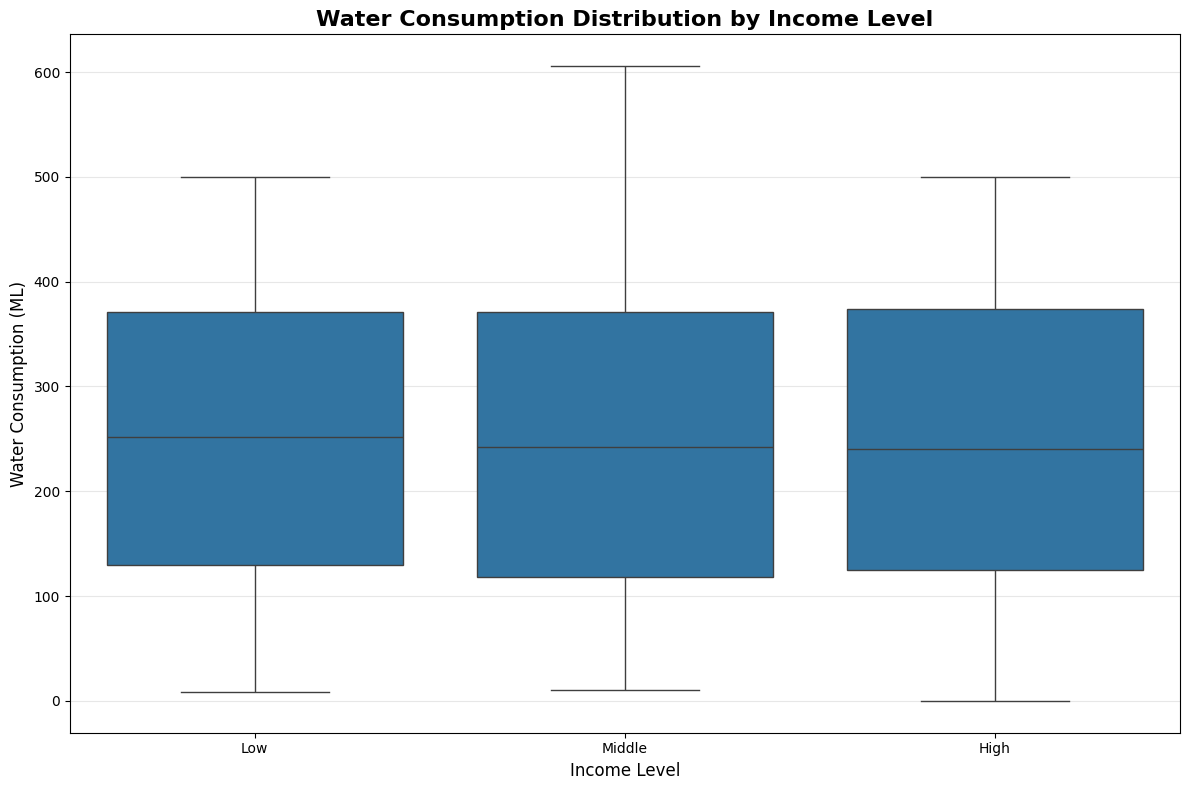

Insight: This shows how water consumption varies across different income levels.


In [20]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_pandas, x='income_level', y='Consumption_in_ML', 
            order=['Low', 'Middle', 'High'])
plt.title('Water Consumption Distribution by Income Level', fontsize=16, fontweight='bold')
plt.xlabel('Income Level', fontsize=12)
plt.ylabel('Water Consumption (ML)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Insight: This shows how water consumption varies across different income levels.")

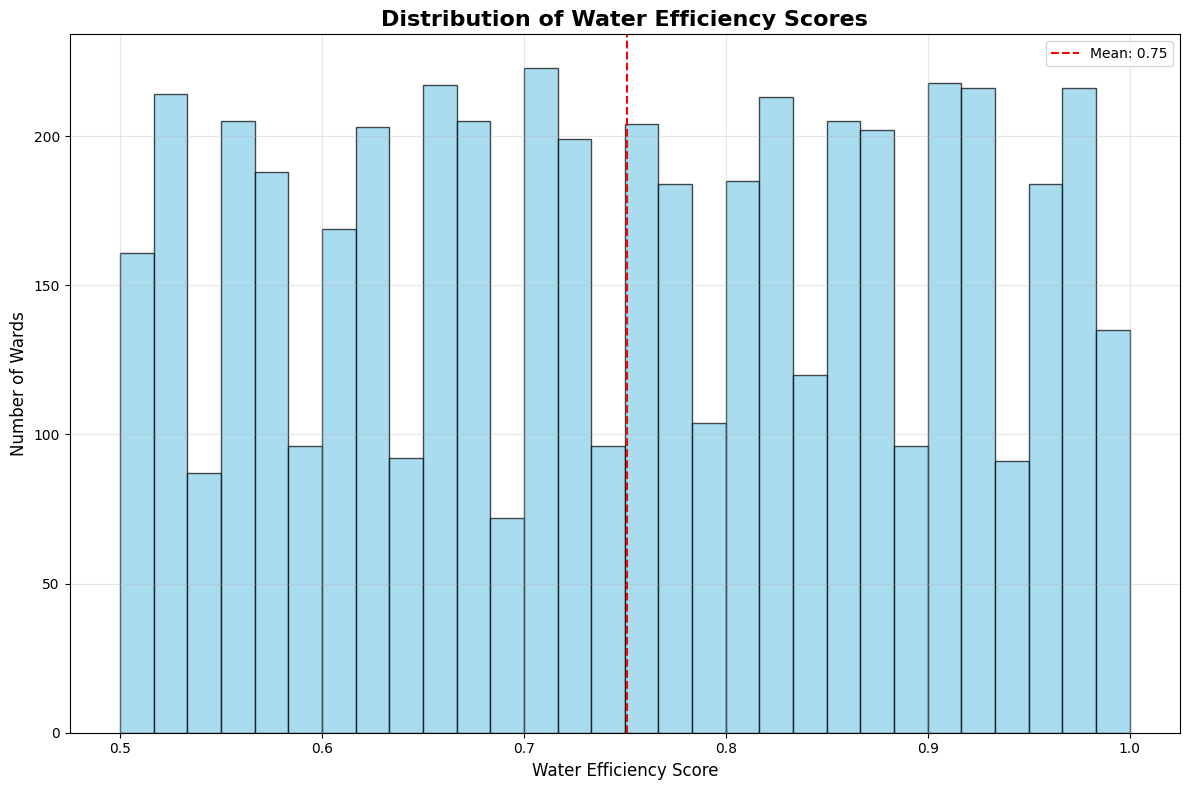

In [21]:
plt.figure(figsize=(12, 8))
plt.hist(df_pandas['water_efficiency'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Water Efficiency Scores', fontsize=16, fontweight='bold')
plt.xlabel('Water Efficiency Score', fontsize=12)
plt.ylabel('Number of Wards', fontsize=12)
plt.grid(alpha=0.3)
plt.axvline(df_pandas['water_efficiency'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df_pandas["water_efficiency"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

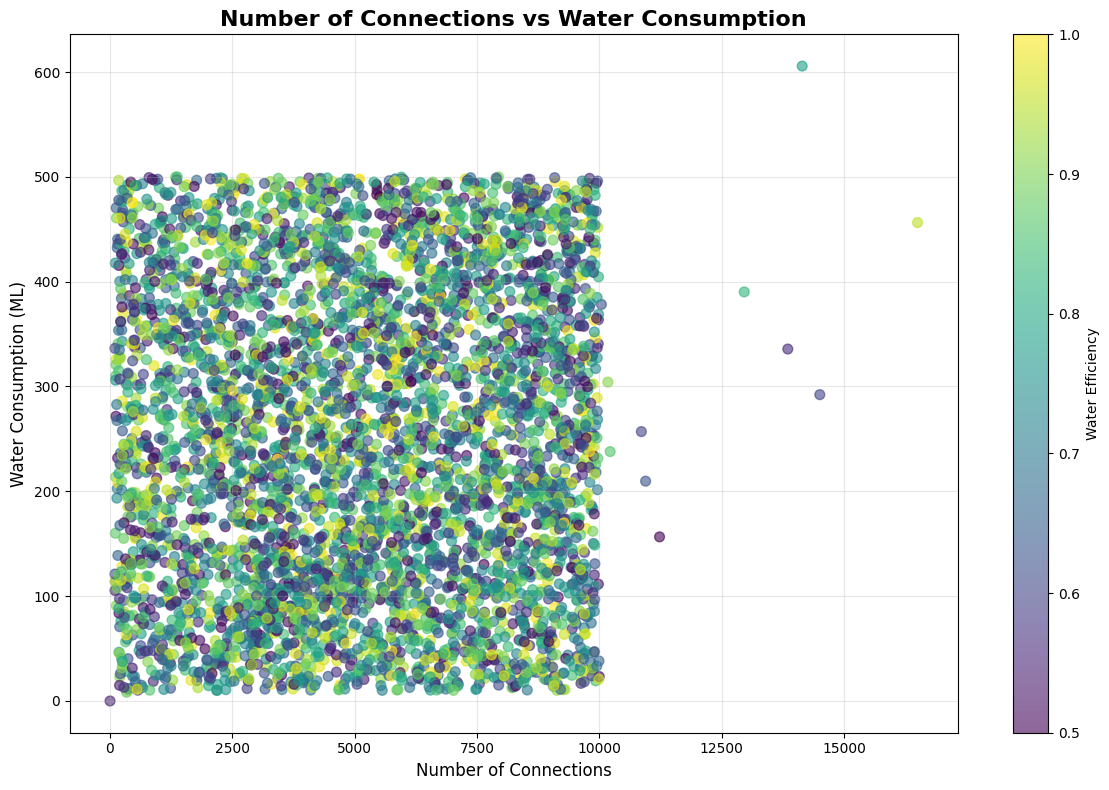

In [22]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_pandas['Number_of_Connections'], df_pandas['Consumption_in_ML'], 
                     c=df_pandas['water_efficiency'], cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Water Efficiency')
plt.title('Number of Connections vs Water Consumption', fontsize=16, fontweight='bold')
plt.xlabel('Number of Connections', fontsize=12)
plt.ylabel('Water Consumption (ML)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

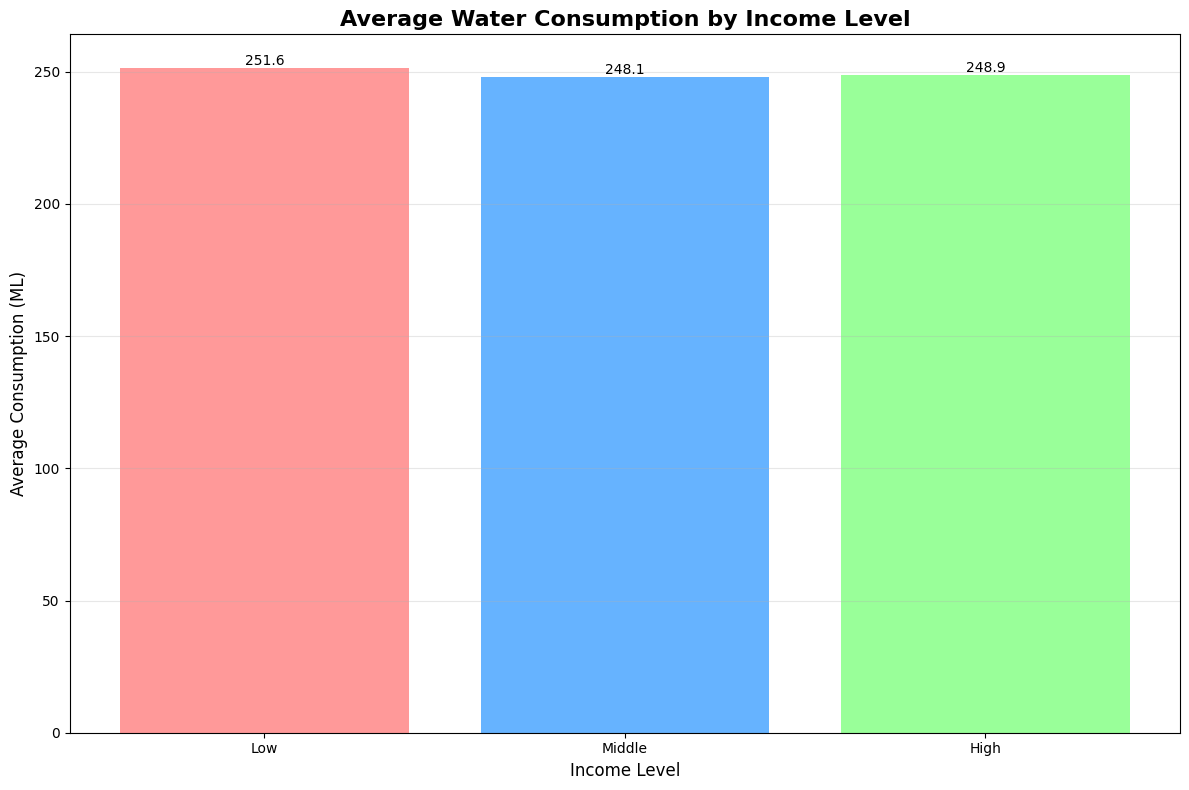

In [23]:
plt.figure(figsize=(12, 8))
consumption_by_income = df_pandas.groupby('income_level')['Consumption_in_ML'].mean().reindex(['Low', 'Middle', 'High'])
bars = plt.bar(consumption_by_income.index, consumption_by_income.values, 
               color=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Average Water Consumption by Income Level', fontsize=16, fontweight='bold')
plt.xlabel('Income Level', fontsize=12)
plt.ylabel('Average Consumption (ML)', fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

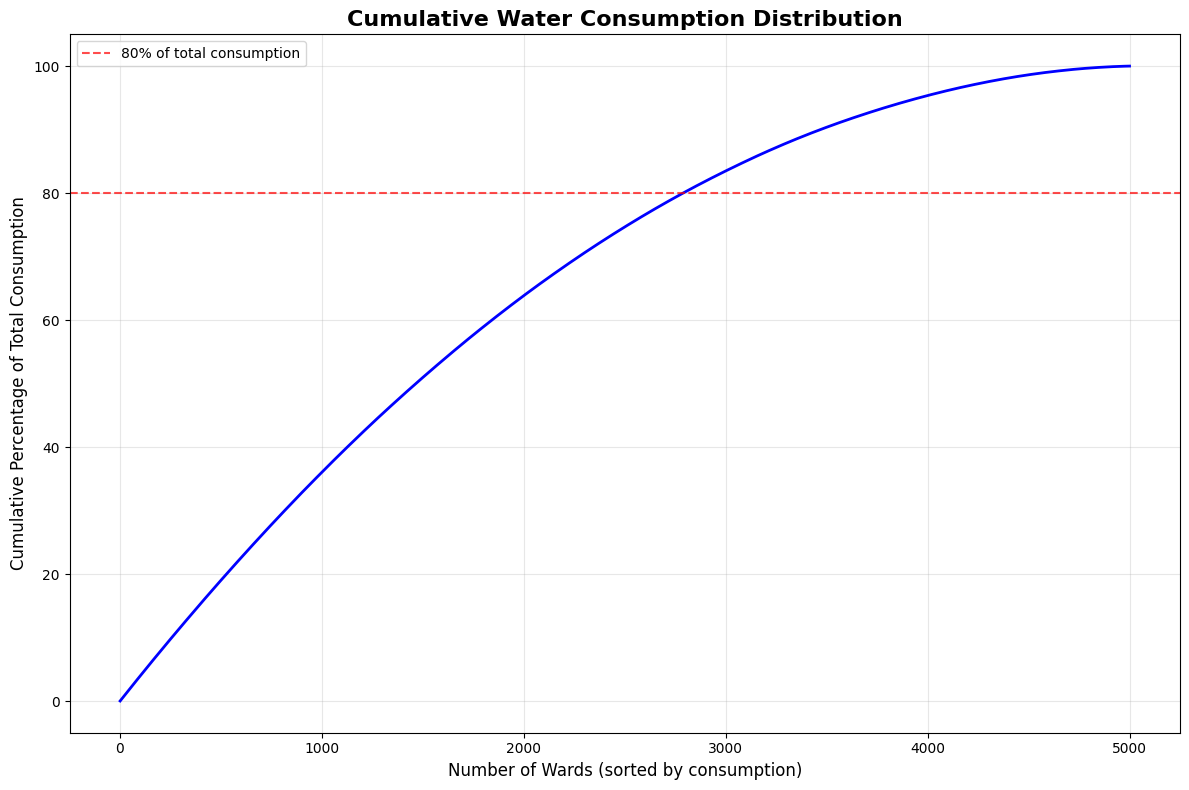

In [24]:
plt.figure(figsize=(12, 8))
df_sorted = df_pandas.sort_values('Consumption_in_ML', ascending=False)
df_sorted['cumulative_consumption'] = df_sorted['Consumption_in_ML'].cumsum()
df_sorted['cumulative_percentage'] = df_sorted['cumulative_consumption'] / df_sorted['Consumption_in_ML'].sum() * 100

plt.plot(range(1, len(df_sorted) + 1), df_sorted['cumulative_percentage'], linewidth=2, color='blue')
plt.axhline(80, color='red', linestyle='--', alpha=0.7, label='80% of total consumption')
plt.title('Cumulative Water Consumption Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Number of Wards (sorted by consumption)', fontsize=12)
plt.ylabel('Cumulative Percentage of Total Consumption', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

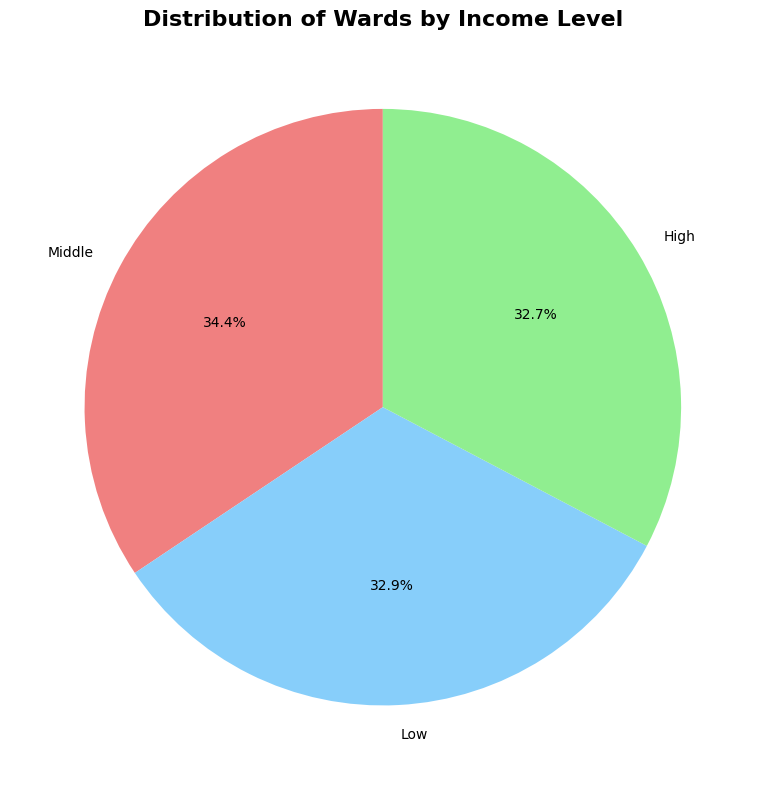

In [25]:
plt.figure(figsize=(10, 8))
income_dist = df_pandas['income_level'].value_counts()
colors = ['lightcoral', 'lightskyblue', 'lightgreen']
plt.pie(income_dist.values, labels=income_dist.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Distribution of Wards by Income Level', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

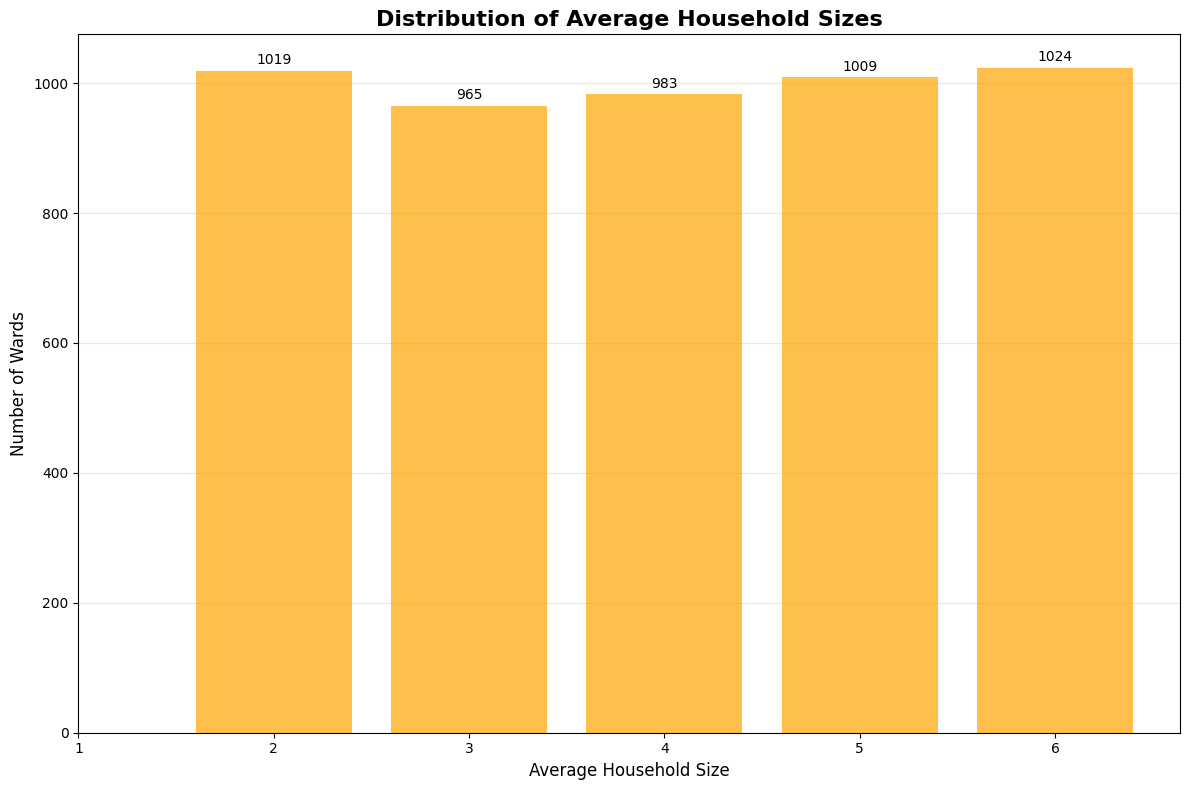

In [26]:
plt.figure(figsize=(12, 8))
household_dist = df_pandas['avg_household_size'].value_counts().sort_index()
plt.bar(household_dist.index, household_dist.values, color='orange', alpha=0.7)
plt.title('Distribution of Average Household Sizes', fontsize=16, fontweight='bold')
plt.xlabel('Average Household Size', fontsize=12)
plt.ylabel('Number of Wards', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(1, 7))

for i, v in enumerate(household_dist.values):
    plt.text(household_dist.index[i], v + 10, str(v), ha='center')

plt.tight_layout()
plt.show()

In [27]:
# Generate final summary report
print("=" * 80)
print("FINAL SUMMARY REPORT - BWSSB WATER CONSUMPTION ANALYSIS")
print("=" * 80)

# Overall statistics
total_consumption = df_enhanced.agg(sum("Consumption_in_ML")).collect()[0][0]
avg_consumption = df_enhanced.agg(avg("Consumption_in_ML")).collect()[0][0]
avg_efficiency = df_enhanced.agg(avg("water_efficiency")).collect()[0][0]

print(f"\nOVERALL STATISTICS:")
print(f"Total Wards Analyzed: {df_enhanced.count()}")
print(f"Total Water Consumption: {total_consumption:,.2f} ML")
print(f"Average Consumption per Ward: {avg_consumption:.2f} ML")
print(f"Average Water Efficiency: {avg_efficiency:.3f}")

# Top consuming wards
print(f"\nTOP 5 CONSUMING WARDS:")
top_5 = df_enhanced.orderBy(col("Consumption_in_ML").desc()).limit(5)
top_5.select("Ward_Name", "Consumption_in_ML", "income_level", "water_efficiency").show(truncate=False)

# Efficiency leaders
print(f"\nTOP 5 MOST EFFICIENT WARDS:")
efficient_5 = df_enhanced.orderBy(col("water_efficiency").desc()).limit(5)
efficient_5.select("Ward_Name", "water_efficiency", "Consumption_in_ML", "income_level").show(truncate=False)

# Income level summary
print(f"\nCONSUMPTION BY INCOME LEVEL:")
income_summary_final = df_enhanced.groupBy("income_level").agg(
    count("*").alias("Wards"),
    sum("Consumption_in_ML").alias("Total_Consumption_ML"),
    avg("Consumption_in_ML").alias("Avg_Consumption_ML"),
    avg("water_efficiency").alias("Avg_Efficiency")
).orderBy("Total_Consumption_ML", ascending=False)
income_summary_final.show()

print("=" * 80)
print("ANALYSIS COMPLETED SUCCESSFULLY")
print("=" * 80)

FINAL SUMMARY REPORT - BWSSB WATER CONSUMPTION ANALYSIS

OVERALL STATISTICS:
Total Wards Analyzed: 5000
Total Water Consumption: 1,247,476.12 ML
Average Consumption per Ward: 249.50 ML
Average Water Efficiency: 0.751

TOP 5 CONSUMING WARDS:
+-------------------+-----------------+------------+----------------+
|Ward_Name          |Consumption_in_ML|income_level|water_efficiency|
+-------------------+-----------------+------------+----------------+
|HSR Layout         |605.66           |Middle      |0.78            |
|Synthetic Ward 4753|499.98           |High        |0.84            |
|Synthetic Ward 2405|499.88           |High        |0.9             |
|Synthetic Ward 2261|499.75           |Low         |0.82            |
|Synthetic Ward 622 |499.66           |Low         |0.89            |
+-------------------+-----------------+------------+----------------+


TOP 5 MOST EFFICIENT WARDS:
+------------------+----------------+-----------------+------------+
|Ward_Name         |water_effi

In [30]:
# Stop Spark session
spark.stop()
print("Spark session stopped successfully.")

Spark session stopped successfully.
